# Linear Regression Diagonostics


_In economics, the majority is always wrong_ - John Kenneth Galbraith

For a linear regression model to produce reliable and interpretable results, it must satisfy certain assumptions. Diagnosing potential issues such as heteroskedasticity, multicollinearity, omitted variables, and influential data points is important for model validity. We explore key diagnostic tests for linear regression, including methods for detecting violations of assumptions, evaluating the impact of outliers, and assessing model fit through residual plots. Additionally, we discuss techniques for robust standard errors when assumptions are violated, such as heteroskedasticity- and autocorrelation-consistent (HAC) estimators. 

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import pandas as pd
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import patsy
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from finds.readers import Alfred
from finds.utils import plot_fitted, plot_leverage, plot_scale, plot_qq
from secret import credentials
VERBOSE = 0
# matplotlib qt

In [2]:
alf = Alfred(api_key=credentials['fred']['api_key'])

For this analysis, we retrieve monthly Consumer Price Index (CPI) data as the dependent (endogenous) variable and Producer Price Index (PPI) data as the independent (exogenous) variable. The model uses the monthly differences of the logarithms of both series to account for changes over time.  

In [3]:
# difference of logs of CPI and PPI monthly series from FRED
series_id, freq, start = 'CPIAUCSL', 'M', 0   #19740101
exog_id = 'WPSFD4131'

data = pd.concat([alf(s, start=start) for s in [series_id, exog_id]], axis=1)
data.index = pd.DatetimeIndex(data.index.astype(str))
data = np.log(data).diff().dropna()  # model the changes in logs of the series
DataFrame.from_dict({s: alf.header(s) for s in [series_id, exog_id]},
                    orient='index', columns=['Description'])

,Description
CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
WPSFD4131,Producer Price Index by Commodity: Final Deman...


## Model assumptions

A valid linear regression model must satisfy the following assumptions:  

1. **Linearity**: The expected value of $ y_i $ follows a linear function of the independent variables:  
   $$
   E[y_i] = b_0 + b_1 x_{i1} + ... + b_k x_{ik}
   $$  
2. **Exogeneity**: The explanatory variables $ \{x_{i1} ,...,x_{ik} \} $ are non-stochastic and not correlated with the error term.  
3. **Homoscedasticity**: The variance of the dependent variable remains constant:  
   $$
   Var(y_i) = \sigma^2
   $$  
4. **Independence**: The observations $ \{ y_i \} $ are independent of each other.  
5. **Normality**: The error terms follow a normal distribution.  

When assumptions 1-4 hold, the least squares estimator:  

- Provides an **unbiased** estimate of the regression coefficients:  
  $$
  b = (X' X)^{-1} X' y
  $$  
- Has a variance-covariance matrix:  
  $$
  Var(b) = \sigma^2 (X' X)^{-1}
  $$  
- The standard error for each coefficient $ b_j $ is:  
  $$
  se(b_j) = \sigma \sqrt{(X' X)^{-1}_{[j+1,j+1]}}
  $$  

When all five assumptions hold, the least squares estimator follows a normal distribution, enabling valid statistical inference.  




In [4]:
# Run Linear Regression (with exog and 2 lags)
dmf = (f'{series_id} ~ {series_id}.shift(1) + {series_id}.shift(2) + {exog_id}.shift(1)')
model = smf.ols(formula=dmf, data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     167.5
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           4.43e-79
Time:                        22:25:01   Log-Likelihood:                 2815.2
No. Observations:                 610   AIC:                            -5622.
Df Residuals:                     606   BIC:                            -5605.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0009      0

### Heteroskedasity and HAC robust errors

If the variance of residuals is not constant (**heteroskedasticity**), the usual **Ordinary Least Squares (OLS)** standard error formula, $ \sigma^2 (X' X)^{-1} $, no longer holds. While OLS coefficient estimates remain **consistent**, their standard errors may be misestimated. A more general form of the variance-covariance matrix is:  

$$
(X' X)^{-1}(X' \Omega X)(X' X)^{-1}
$$

where different choices of $ \Omega $ provide **robust standard error estimators**.  

- **White’s (1980) heteroskedasticity-consistent estimator** (also known as the sandwich estimator) uses the diagonal of squared residuals.
- Alternative estimators account for leverage effects in the design matrix.  

If error terms exhibit **serial correlation**, standard heteroskedasticity-robust errors may still be misleading. **Newey and West (1987)** introduced the **Heteroskedasticity and Autocorrelation Consistent (HAC)** estimator, which applies a weighting scheme to correct for autocorrelation. The truncation parameter for lag selection is often chosen as:  

$$
m = 0.75 T^{1/3}
$$

where autocorrelation coefficients are weighted as follows:  

$$
1 + 2 \sum_{j=1}^{m-1} \dfrac{m-j}{m} \hat{\rho_j}
$$



In [5]:

robust = model.get_robustcov_results(cov_type='HAC', use_t=None, maxlags=0)
print(robust.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     108.8
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           2.25e-56
Time:                        22:25:01   Log-Likelihood:                 2815.2
No. Observations:                 610   AIC:                            -5622.
Df Residuals:                     606   BIC:                            -5605.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0009      0

### Multicollinearity and variance inflation factors

Multicollinearity arises when explanatory variables are highly correlated, leading to unstable coefficient estimates. The **Variance Inflation Factor (VIF)** quantifies the degree of multicollinearity by measuring how much a predictor’s variance is inflated due to correlation with other predictors:  

$$
\mathrm{VIF_i} = \dfrac{1}{1-R^2_i}
$$

where $ R^2_i $ is obtained by regressing $ X_i $ on all other predictors.  

A VIF > 5 or 10 suggests that the variable is highly collinear with other explanatory variables, potentially leading to large standard errors and unreliable estimates.  

In [6]:
Y, X = patsy.dmatrices(dmf + ' - 1', data=data)  # exclude intercept term  
print("Variance Inflation Factors")
Series({X.design_info.column_names[i]: variance_inflation_factor(X, i)
        for i in range(X.shape[1])}, name='VIF').to_frame()

Variance Inflation Factors


,VIF
CPIAUCSL.shift(1),3.414717
CPIAUCSL.shift(2),3.404137
WPSFD4131.shift(1),2.285974


### Omitted variables

Leaving out an important variable from the regression model can lead to biased estimates. The consequences are:  

1. **Bias in Included Variables**: If the omitted variable is correlated with included variables, their regression coefficients will capture some of its effect, leading to inconsistent estimates.  
2. **Inflated Residual Variance**: The estimated residuals will include both true shocks and the effects of the omitted variable, reducing model accuracy.  

Conversely, including an extraneous (irrelevant) variable does not introduce bias but increases standard errors, making it harder to detect significant effects.  


## Residual diagnostics

Residual plots help evaluate model fit, identify outliers and detect potential specification issues.  
An ideal model would have residuals that are not systematically related to any of the included explanatory variables. Standardized residuals may alternatively be used so that the magnitude of deviation is more apparent.

### Residuals vs fitted plot

This plot assesses whether residuals exhibit nonlinear patterns. Ideally, residuals should be randomly scattered around zero, with no discernible trend. A systematic pattern suggests model misspecification or omitted variables.  



Residual Outliers


date,2022-07-31,2008-10-31,2008-11-30
outliers,-0.009815,-0.011066,-0.015599


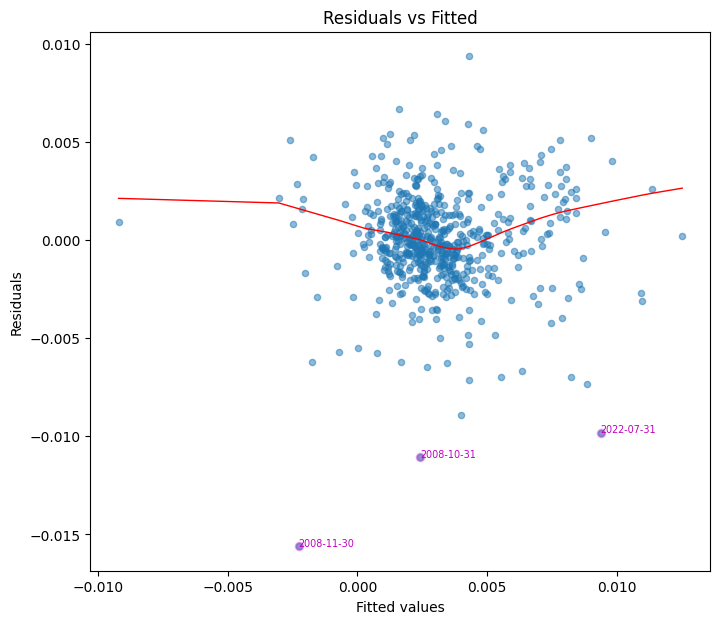

In [7]:
# Plot residuals and identify outliers
fig, ax = plt.subplots(clear=True, figsize=(8,7))
z = plot_fitted(fitted=model.fittedvalues,
                resid=model.resid,
                ax=ax)
print("Residual Outliers")
z.to_frame().T

### Normal QQ plot

A **quantile-quantile (Q-Q) plot** compares residuals to a normal distribution. If residuals are normally distributed, data points should align along a 45-degree reference line. **Outliers** may appear as deviations from this line, indicating potential issues such as a heavy-tailed distribution.  


/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


,residuals,standardized
date,,
2008-11-30,-0.015599,-6.511279
2008-10-31,-0.011066,-4.619178
2022-07-31,-0.009815,-4.097059
2006-09-30,-0.008903,-3.716483
2005-10-31,-0.007321,-3.056102
2013-03-31,-0.007108,-2.967065
2008-08-31,-0.007003,-2.923170
1980-07-31,-0.006997,-2.920733
2005-09-30,0.009362,3.907884


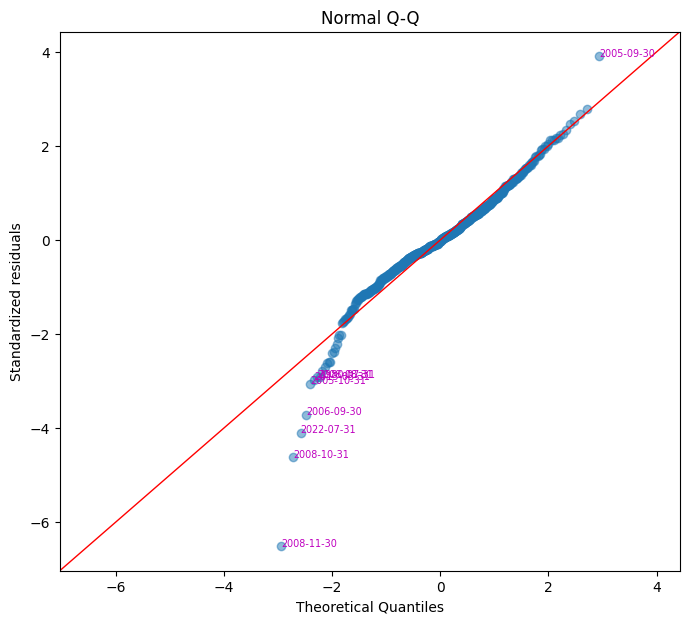

In [8]:
fig, ax = plt.subplots(clear=True, figsize=(8,7))
plot_qq(model.resid, ax=ax)

### Scale-location plot  

This plot checks for homoscedasticity (constant variance). Residuals should be evenly spread across predictor values. A funnel-shaped pattern suggests heteroskedasticity, requiring robust standard errors.  


array([579, 414, 415])

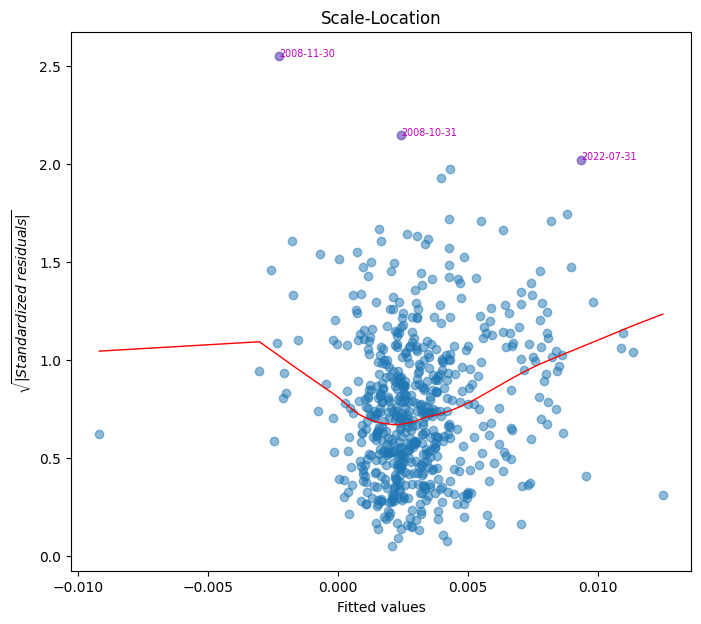

In [9]:
fig, ax = plt.subplots(clear=True, figsize=(8,7))
plot_scale(model.fittedvalues, model.resid, ax=ax)

### Leverage and influential points

Certain data points can disproportionately affect regression estimates. The projection matrix from the least squares estimator, also called the **hat matrix**, $ H = X(X^T X)^{-1}X^T$ identifies **leverage points**, where the diagonal element $ h_{ii} $ measures the influence of the $ i $-th observation.  

A point may have **high leverage** but not necessarily influence the regression results significantly. **Cook’s Distance** measures influence based on both residual magnitude and leverage:  

$$
D_i = \frac{1}{p} t_i^2 \frac{h_{ii}}{1 - h_{ii}}
$$

where:  

- $ p $ is the number of regression parameters.  
- $t_i = \frac{\hat{\epsilon}_i}{\hat{\sigma} (1-h_{ii})}$ is the *studentized residual*, which accounts for non-constant variance.
- $\hat{\sigma} = \sqrt{\sum_{j=1}^n \hat{\epsilon}_j^2/n}$.  

D_i > 1 $ suggests an influential point that may need further investigation.  The **Residuals vs Leverage plot** helps visualize these influential points.  




,influential,cook's D,leverage
date,,,


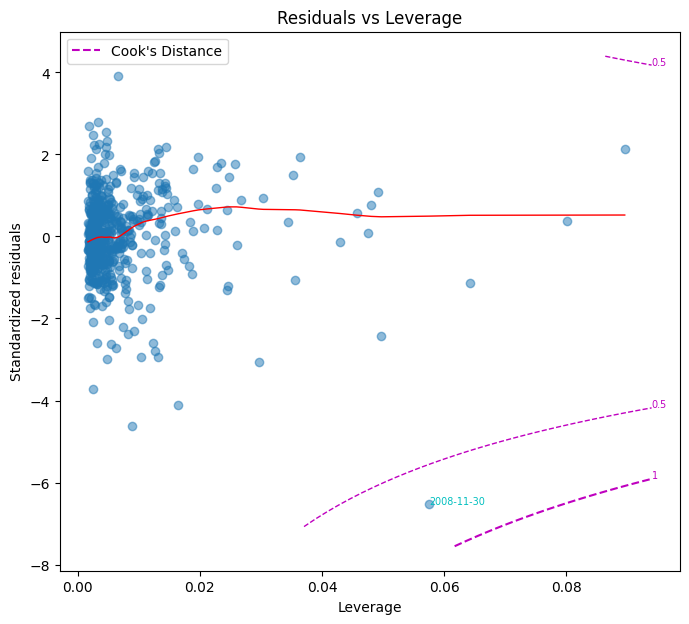

In [10]:
fig, ax = plt.subplots(clear=True, figsize=(8,7))
plot_leverage(model.resid, model.get_influence().hat_matrix_diag,
              model.get_influence().cooks_distance[0],
              ddof=len(model.params), ax=ax)


__References:__

White, Halbert (1980). "A Heteroskedasticity-Consistent Covariance Matrix Estimator and a Direct Test for Heteroskedasticity". Econometrica. 48 (4): 817–838.

Newey, Whitney K., and Kenneth D. West. 1987. “A Simple, Positive Semi-Definite, Heteroskedasticity and Autocorrelation Consistent Covariance Matrix.” Econometrica 55: 703–8. 

https://library.virginia.edu/data/articles/diagnostic-plots

FRM Part I Exam Book Quantitative Analysis Ch 9